In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [6]:
# 导入小车上山环境

env = gym.make('MountainCar-v0')
env.seed(0)
env = env.unwrapped

print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.min_position, env.max_position)))
print('速度范围 = {}'.format((-env.max_speed, env.max_speed)))
print('目标位置 = {}'.format(env.goal_position))

观测空间 = Box(2,)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


失败退出


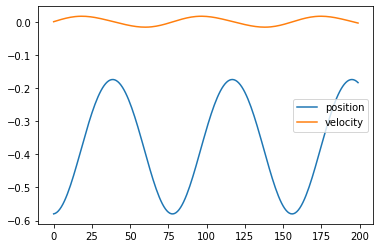

In [12]:
# 总是向右施力的智能体

positions, velocities = [], []
observation = env.reset()

# while True:
for _ in range(200):
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

plt.figure()
plt.plot(positions, label='position')
plt.plot(velocities, label='velocity')
plt.legend()
plt.show()

In [14]:
# 砖瓦编码的实现

class TileCoder(object):
    
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}
        return

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]

        count = len(self.codebook)
        if count >= self.features:
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
    
    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features